# Character Recognition in Natural Scenes with The Chars74K Dataset

This project evaluates a convolutional neural network that I build to identify the alphanumeric characters present in 7700 photographs. The code presented here walks through the process of building and evaluating the model on a number of metrics.

## Citation
[T. E. de Campos](http://personal.ee.surrey.ac.uk/Personal/T.Decampos/), B. R. Babu and [M. Varma](http://manikvarma.org/). [Character recognition in natural images](http://personal.ee.surrey.ac.uk/Personal/T.Decampos/papers/decampos_etal_visapp2009.pdf). In *Proceedings of the International Conference on Computer Vision Theory and Applications (VISAPP), Lisbon, Portugal*, February 2009.

## Data Exploration

In [1]:
# import libraries

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.utils import to_categorical

In [2]:
# functions and constants

SAMPLES = 7700 


def get_raw_data_and_labels(sparse = False):
    images = []
    image_paths = []
    labels = np.zeros(shape=(SAMPLES,), dtype=int)
    img_num = 0
    for img_sample_dir in sorted(glob.glob('English\Img\GoodImg\Bmp\*')):
        
        subdir = glob.glob(img_sample_dir + '\*')
        for image_path in subdir:
            image_paths.append(image_path)
            images.append(imread(image_path))
            
            # grab last two characters of sample directory, which will be a pair of numbers (e.g. 01),
            # convert that numeric string to an integer, then subtract 1 and set that value to be the label
            
            labels[img_num] = int(img_sample_dir[-2:]) - 1
            img_num += 1
    
    if sparse == False : labels = to_categorical(labels, 62)
    return image_paths, images, labels


def get_image_dimensions(images):
    image_dimensions = np.zeros(shape=(SAMPLES, 2))
    num = 0
    for image in images:
        image_dimensions[num, 0] = image.shape[0]
        image_dimensions[num, 1] = image.shape[1]
        num += 1
    
    return image_dimensions

Using the function defined above, I retrieve the raw image data and the ground truth labels. I also save the paths to the images since I will need to access them again.

In [3]:
# get image data and labels

image_paths, raw_images, labels = get_raw_data_and_labels(sparse=False)

The first thing to do after getting the data is some initial data exploration. For image data, this stage has less breadth than what may be seen in other types of data science projects, but it still helps to provide some insight into which specific techniques may be helpful. In this case, I look at the distribution of class labels and the dimensions of the images as provided.

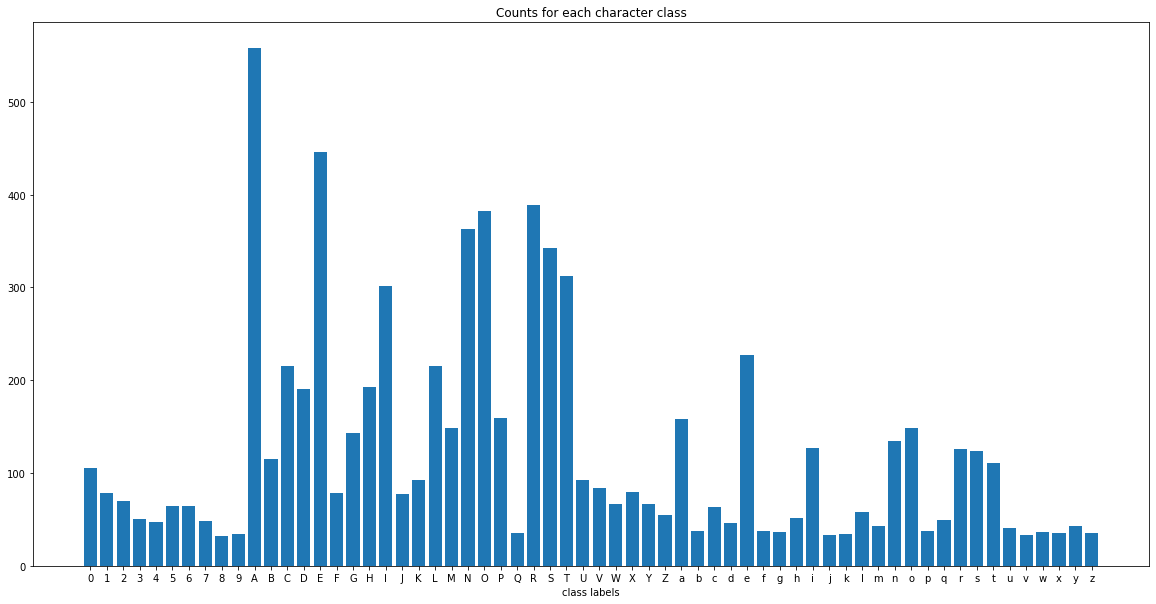

range: 526.0
mean: 124.194
median: 78.0


In [4]:
# plot counts per class

classes = [
    '0','1','2','3','4','5','6','7','8','9',
    'A','B','C','D','E','F','G','H','I','J','K','L','M',
    'N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
    'a','b','c','d','e','f','g','h','i','j','k','l','m',
    'n','o','p','q','r','s','t','u','v','w','x','y','z']

counts_per_class = labels.sum(axis=0)

plt.figure(figsize=(20,10))
plt.bar(range(62), counts_per_class)
plt.title('Counts for each character class')
plt.xlabel('class labels')
plt.xticks(range(62), classes)
plt.show()

max_val = max(counts_per_class)
min_val = min(counts_per_class)

print(f'range: {max_val - min_val}')

mean = np.mean(counts_per_class)
print(f'mean: {mean:.3f}')

median = np.median(counts_per_class)
print(f'median: {median}')

The bar plot of the class labels shows a marked imbalance in the data. This is not too surprising since the data is taken from photographs of signs and lettering in the physical world, where the frequency of any character is directly dependent upon how frequently it is used in the English language. In general, we see that capital letters are more common than lowercase letters (since many signs use exclusively all-caps lettering), and letters we expect to be common from our experience - such as vowels and the consonants N, R, S, and T - are the most represented classes.

Some other statistics to note about the class distribution are its maximum value, 558 for capital A; its minimum value, 32 for number 8; the corresponding range, 526; and the mean and median values, 124.19 and 78. The mean being greater than the median indicates that the most represented classes are significantly more common than the median class, which matches the impression I get from the plot.

Using these class frequencies, I compute weights for each class based on their multiplicative relationship to the most common class - that is, the count of a particular class times its weight returns the maximum count value.

In [5]:
# set class weights

class_weights = {}

for i in range(62):
    class_weights[i] = max_val/counts_per_class[i]
    
print(class_weights)

{0: 5.3142858, 1: 7.063291, 2: 7.9714284, 3: 11.16, 4: 11.87234, 5: 8.71875, 6: 8.71875, 7: 11.625, 8: 17.4375, 9: 16.411764, 10: 1.0, 11: 4.852174, 12: 2.5953488, 13: 2.9214659, 14: 1.251121, 15: 7.063291, 16: 3.902098, 17: 2.8911917, 18: 1.8476821, 19: 7.246753, 20: 6.0652175, 21: 2.5953488, 22: 3.7449665, 23: 1.5371901, 24: 1.4607329, 25: 3.509434, 26: 15.942857, 27: 1.4344473, 28: 1.6315789, 29: 1.7884616, 30: 6.0652175, 31: 6.642857, 32: 8.328359, 33: 6.975, 34: 8.328359, 35: 10.145454, 36: 3.5316455, 37: 14.684211, 38: 8.857142, 39: 12.130435, 40: 2.4581497, 41: 15.081081, 42: 15.5, 43: 10.730769, 44: 4.3937006, 45: 16.90909, 46: 16.411764, 47: 9.620689, 48: 12.976745, 49: 4.133333, 50: 3.7702703, 51: 15.081081, 52: 11.387755, 53: 4.428571, 54: 4.5, 55: 5.027027, 56: 13.609756, 57: 16.90909, 58: 15.5, 59: 15.942857, 60: 12.976745, 61: 15.942857}


I am also interested in the image dimensions of this dataset. The convolusional layers of the model will require every input array to have the same dimensions, so exploring the distribution of dimensions present in the data will offer some insight into what dimensions may be reasonable.

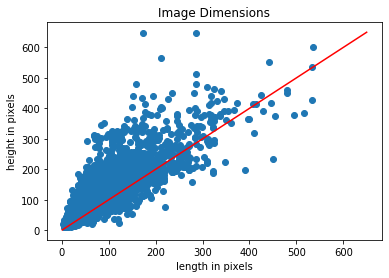

In [6]:
# plot image dimensions

image_dimensions = get_image_dimensions(raw_images)

lengths = image_dimensions[:,1]
heights = image_dimensions[:,0]

plt.scatter(lengths, heights)
plt.plot([1, 650], [1,650], 'r-')
plt.title('Image Dimensions')
plt.xlabel('length in pixels')
plt.ylabel('height in pixels')
plt.show()

The above scatter plot of the data shows that more points are clustered toward the bottom left, so smaller images tend to be more common than larger ones. We also see that images tend to be taller than they are wide.

When resizing the images, I plan to use the same value for the height and length for simplicity. My expectation is that key features of each character will still be indentifiable to the model; if anything, some degree of distortion may actually help the model identify a wider range of character styles since this kind of transformation is also a standard technique used in data augmentation.

Since height and width will be identical, I set out to determine an appropriate range of values by computing the square root of each image's area and plotting the values on a histogram. The first plot exhibits a strong right skew, which matches our intuition from the scatter plot, so I make a second plot that re-scales the data logarithmically.

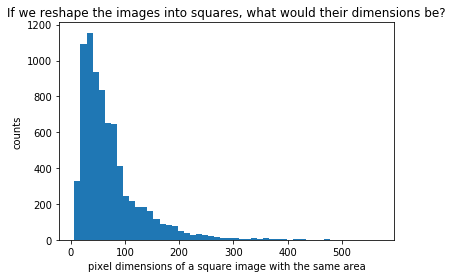

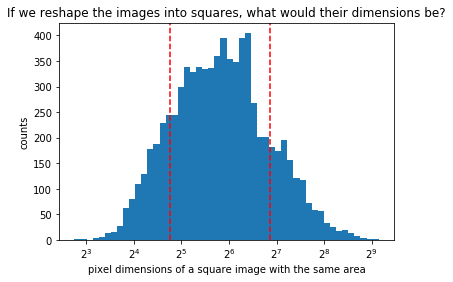

In [28]:
# plot image areas to determine appropriate resizing

areas = lengths * heights
square_lengths = np.sqrt(areas)
hist, bins, _ = plt.hist(square_lengths, bins=50)
plt.title('If we reshape the images into squares, what would their dimensions be?')
plt.xlabel('pixel dimensions of a square image with the same area')
plt.ylabel('counts')
plt.show()

logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

plt.hist(square_lengths, bins=logbins)
plt.axvline(np.quantile(square_lengths, .16), color='r', linestyle='--')
plt.axvline(np.quantile(square_lengths, .84), color='r', linestyle='--')
plt.xscale('log', basex=2)
plt.title('If we reshape the images into squares, what would their dimensions be?')
plt.xlabel('pixel dimensions of a square image with the same area')
plt.ylabel('counts')
plt.show()

Though the image dimensions themselves are not essential to any key statistics of the model, I find the appearance of what is approximately a normal distribution in the logarithmic plot to be pleasing. The powers of two even appear to be reasonable approximations of the standard deviation on this scale. At any rate, an appropriate side length for the square images appears to range from about $2^5$ to $2^7$, or 32 to 128.

I will implement progressive resizing on this range of dimensions when I design the model. In essence, progressive resizing involves first training on an initial generation of a model, then re-using the layers and weights from the first model in a second generation that takes upscaled images as input. By starting with low resolution images and gradually upscaling those images, the model is able to more easily identify the more robust features of the classes before moving on to identify smaller details. Informed by the range of dimensions found above, I intend to implement three generations, using 32x32, 64x64, and 128x128 sized images.

## Building and Training the Model

In [8]:
# import libraries

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Activation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [9]:
# functions

def resize_all_images(image_paths, size):
    resized_images = np.zeros(shape=(SAMPLES, size, size, 3))
    img_num = 0
    for image in image_paths:
        temp_image = resize(imread(image), (size, size, 3))
        resized_images[img_num] = temp_image
        img_num += 1
        
    return resized_images


def plot_model_history(history):
    plt.plot(history['loss'], label='training')
    plt.plot(history['val_loss'], label='validation')
    plt.title('loss score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.legend()
    plt.show()
    
    plt.plot(history['accuracy'], label='training')
    plt.plot(history['val_accuracy'], label='validation')
    plt.title('accuracy score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.legend()

In [10]:
# resize and split data, 32x32

size = 32
X = resize_all_images(image_paths, size)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

Each generation of the model uses a different training set; while each generation will use a portion of the training set for validation, only the final generation will be tested on the split's testing set.

In [11]:
# CNN layers, 32x32

layers = [
    Conv2D(128, kernel_size=3, padding='same', activation='relu', input_shape=(size, size, 3)),
    MaxPooling2D(padding='same'),
    Dropout(0.2),
    
    Conv2D(256, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(padding='same'),
    Dropout(0.2),
    
    Conv2D(512, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(padding='same'),
    Dropout(0.2),
    
    Flatten(),
    Dense(2048, activation='relu'),
    Dropout(0.2),
    
    Dense(62),
    Activation('softmax')]

model_1 = Sequential()
for layer in layers:
    model_1.add(layer)

Two callbacks are implemented in each generation. The first reduces the learning rate if no significant improvement in the validation loss is achieved within a given number of epochs. The second saves the best version of a model on a given metric; this saved model will become the base of future generations, or, in the case of the last generation, it will be the model on which final evaluation is performed.

Epoch 1/30
73/73 [==============================] - 90s 1s/step - loss: 18.4792 - accuracy: 0.0145 - val_loss: 4.1259 - val_accuracy: 0.0097
Epoch 2/30
73/73 [==============================] - 83s 1s/step - loss: 18.4189 - accuracy: 0.0266 - val_loss: 4.1253 - val_accuracy: 0.0143
Epoch 3/30
73/73 [==============================] - 78s 1s/step - loss: 18.4210 - accuracy: 0.0190 - val_loss: 4.1279 - val_accuracy: 0.0026
Epoch 4/30
73/73 [==============================] - 86s 1s/step - loss: 18.4177 - accuracy: 0.0104 - val_loss: 4.1303 - val_accuracy: 0.0026
Epoch 5/30
73/73 [==============================] - 91s 1s/step - loss: 18.4064 - accuracy: 0.0108 - val_loss: 4.1134 - val_accuracy: 0.0065
Epoch 6/30
73/73 [==============================] - 79s 1s/step - loss: 18.3979 - accuracy: 0.0054 - val_loss: 4.1242 - val_accuracy: 0.0071
Epoch 7/30
73/73 [==============================] - 78s 1s/step - loss: 18.4166 - accuracy: 0.0069 - val_loss: 4.1278 - val_accuracy: 0.0019
Epoch 8/30
73

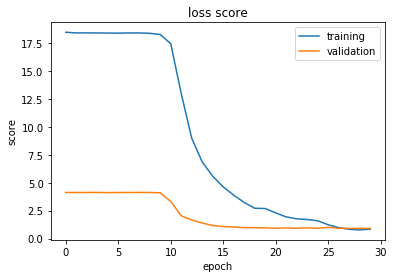

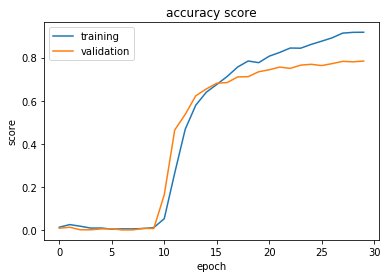

In [12]:
# build and run model, 32x32

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=0.01)
mc = ModelCheckpoint('best_model_32.h5', monitor='val_loss', mode='min', save_best_only=True)

model_1.compile('adam', 'categorical_crossentropy', ['accuracy'])

model_1.fit(X_train, y_train, 
          epochs=30, batch_size=64, 
          validation_split=0.25, 
          class_weight=class_weights, 
          callbacks=[reduce_lr, mc])

plot_model_history(model_1.history.history)

The training loss is initially much higher than the validation loss, which I thought was unusual. As best as I can tell, this is probably a result of the training model also being subject to regularization loss via the dropout layers. The gap between the two loss scores shrinks to nothing after the model begins its climb down the gradient descent.

The 29th epoch displays the best validation loss, and the validation accuracy at that stage is about 78.05%. This is the version of the model that gets saved for future use.

In [13]:
# resize and split data, 64x64

size = 64
X = resize_all_images(image_paths, size)

X_train, X_test, y_train, y_test = train_test_split(X, labels, stratify=labels, train_size=0.8)

The second generation takes on a new set of three layers to accomodate the different input shape before the layers from the pre-trained model are added on top. I experimented with keeping the weights of the pre-trained layers frozen, but I actually found that my results improved when keeping the layers unfrozen.

In [14]:
# CNN layers, 64x64

model_2 = Sequential()

model_2.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=(size, size, 3)))
model_2.add(MaxPooling2D(padding='same'))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))

prior = load_model('best_model_32.h5')
for layer in prior.layers[1:]:
    model_2.add(layer)

Epoch 1/30
73/73 [==============================] - 115s 2s/step - loss: 15.8836 - accuracy: 0.2303 - val_loss: 1.3996 - val_accuracy: 0.6136
Epoch 2/30
73/73 [==============================] - 116s 2s/step - loss: 5.6734 - accuracy: 0.6478 - val_loss: 0.6796 - val_accuracy: 0.8058
Epoch 3/30
73/73 [==============================] - 115s 2s/step - loss: 3.6926 - accuracy: 0.7563 - val_loss: 0.5582 - val_accuracy: 0.8188
Epoch 4/30
73/73 [==============================] - 113s 2s/step - loss: 2.8915 - accuracy: 0.7981 - val_loss: 0.5682 - val_accuracy: 0.8162
Epoch 5/30
73/73 [==============================] - 117s 2s/step - loss: 2.4800 - accuracy: 0.8052 - val_loss: 0.5542 - val_accuracy: 0.8299
Epoch 6/30
73/73 [==============================] - 114s 2s/step - loss: 2.1405 - accuracy: 0.8253 - val_loss: 0.5821 - val_accuracy: 0.8026
Epoch 7/30
73/73 [==============================] - 120s 2s/step - loss: 1.9608 - accuracy: 0.8372 - val_loss: 0.5115 - val_accuracy: 0.8299
Epoch 8/30
7

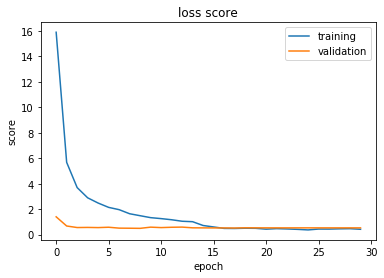

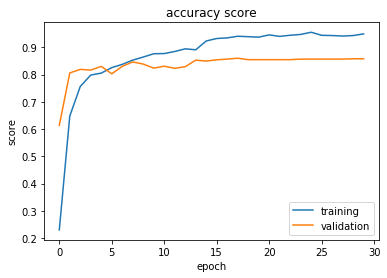

In [15]:
# run model, 64x64

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=0.01)
mc = ModelCheckpoint('best_model_64.h5', monitor='val_loss', mode='min', save_best_only=True)    
    
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.fit(X_train, y_train, epochs=30,
          batch_size=64, validation_split=0.25,
          class_weight=class_weights, callbacks=[reduce_lr, mc])

plot_model_history(model_2.history.history)

The new model shows some improvement on the prior model, with the saved version scoring 0.4954 on the validation loss  and 83.83% on the validation accuracy.

In [16]:
# resize and split data, 128x128

size = 128
X = resize_all_images(image_paths, size)

X_train, X_test, y_train, y_test = train_test_split(X, labels, stratify=labels, train_size=0.8)

In [17]:
# layers, 128x128

model_3 = Sequential()

model_3.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(size, size, 3)))
model_3.add(MaxPooling2D(padding='same'))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))

prior = load_model('best_model_64.h5')
for layer in prior.layers[1:]:
    model_3.add(layer)

Epoch 1/30
73/73 [==============================] - 221s 3s/step - loss: 5.4273 - accuracy: 0.6903 - val_loss: 0.5501 - val_accuracy: 0.8292
Epoch 2/30
73/73 [==============================] - 178s 2s/step - loss: 2.6855 - accuracy: 0.8043 - val_loss: 0.4506 - val_accuracy: 0.8695
Epoch 3/30
73/73 [==============================] - 173s 2s/step - loss: 1.9255 - accuracy: 0.8390 - val_loss: 0.5551 - val_accuracy: 0.8331
Epoch 4/30
73/73 [==============================] - 173s 2s/step - loss: 1.6823 - accuracy: 0.8539 - val_loss: 0.4672 - val_accuracy: 0.8649
Epoch 5/30
73/73 [==============================] - 171s 2s/step - loss: 1.6056 - accuracy: 0.8597 - val_loss: 0.5583 - val_accuracy: 0.8169
Epoch 6/30
73/73 [==============================] - 170s 2s/step - loss: 1.5205 - accuracy: 0.8671 - val_loss: 0.4612 - val_accuracy: 0.8578
Epoch 7/30
73/73 [==============================] - ETA: 0s - loss: 1.3691 - accuracy: 0.8771
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0

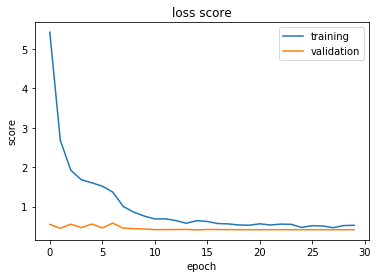

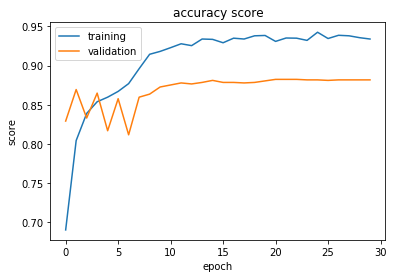

In [18]:
# run model, 128x128

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=0.01)
mc = ModelCheckpoint('best_model_128.h5', monitor='val_loss', mode='min', save_best_only=True)    
    
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_3.fit(X_train, y_train, epochs=30,
          batch_size=64, validation_split=0.25,
          class_weight=class_weights, callbacks=[reduce_lr, mc])

plot_model_history(model_3.history.history)

The final generation of the model again shows marginal improvement over the prior version. This time the validation loss falls to 0.4096, and the validation accuracy rises to 88.12%. The saved version of this model will be the subject of evaluation.

## Evaluation

In [19]:
# import libraries

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

The first step of evaluation is to evaluate the final saved model on the test set. I also use the predictions on the test set to prepare a confusion matrix, which I will use both for visualization purposes and to compute the precision, recall, and f1 scores of the model. The predictions dataframe will be used to more easily identify which features yield the best and worst scores.

In [20]:
# evaluation

best_model = load_model('best_model_128.h5')
results = best_model.evaluate(X_test, y_test, batch_size=128)

predictions = best_model.predict(X_test)
df_predictions = pd.DataFrame(data=[np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)],
                                    index=['true_label', 'predicted_label']).transpose()
cm = confusion_matrix(df_predictions['true_label'], df_predictions['predicted_label'])

13/13 [==============================] - 9s 681ms/step - loss: 0.4082 - accuracy: 0.8740


The test set performs about as well as the validation set, with a slight decrease in both the loss and accuracy scores. A quick overview of other models trained on this dataset suggests that an accuracy of 87.40% is quite strong.

The version of the confusion matrix shown here allows for more in-depth investigation of the results. By first clicking on the bar to the left of the image and then double-clicking on the image itself, you can expand the image to its full size and scroll around the matrix to get a closer look at different regions. The number listed on top inside each cell represents the number of test samples that belong to the class of that cell's row *and* were predicted to be part of the class of that cell's column. The number on the bottom and in parentheses is the fraction of test samples with that row's label to receive that column's prediction - for example, 22% of capital *O*s were predicted to be zeros. For the cells along the main diagonal of the matrix, the number in parentheses is identical to that class's recall score.

(<Figure size 3600x3600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1574682e108>)

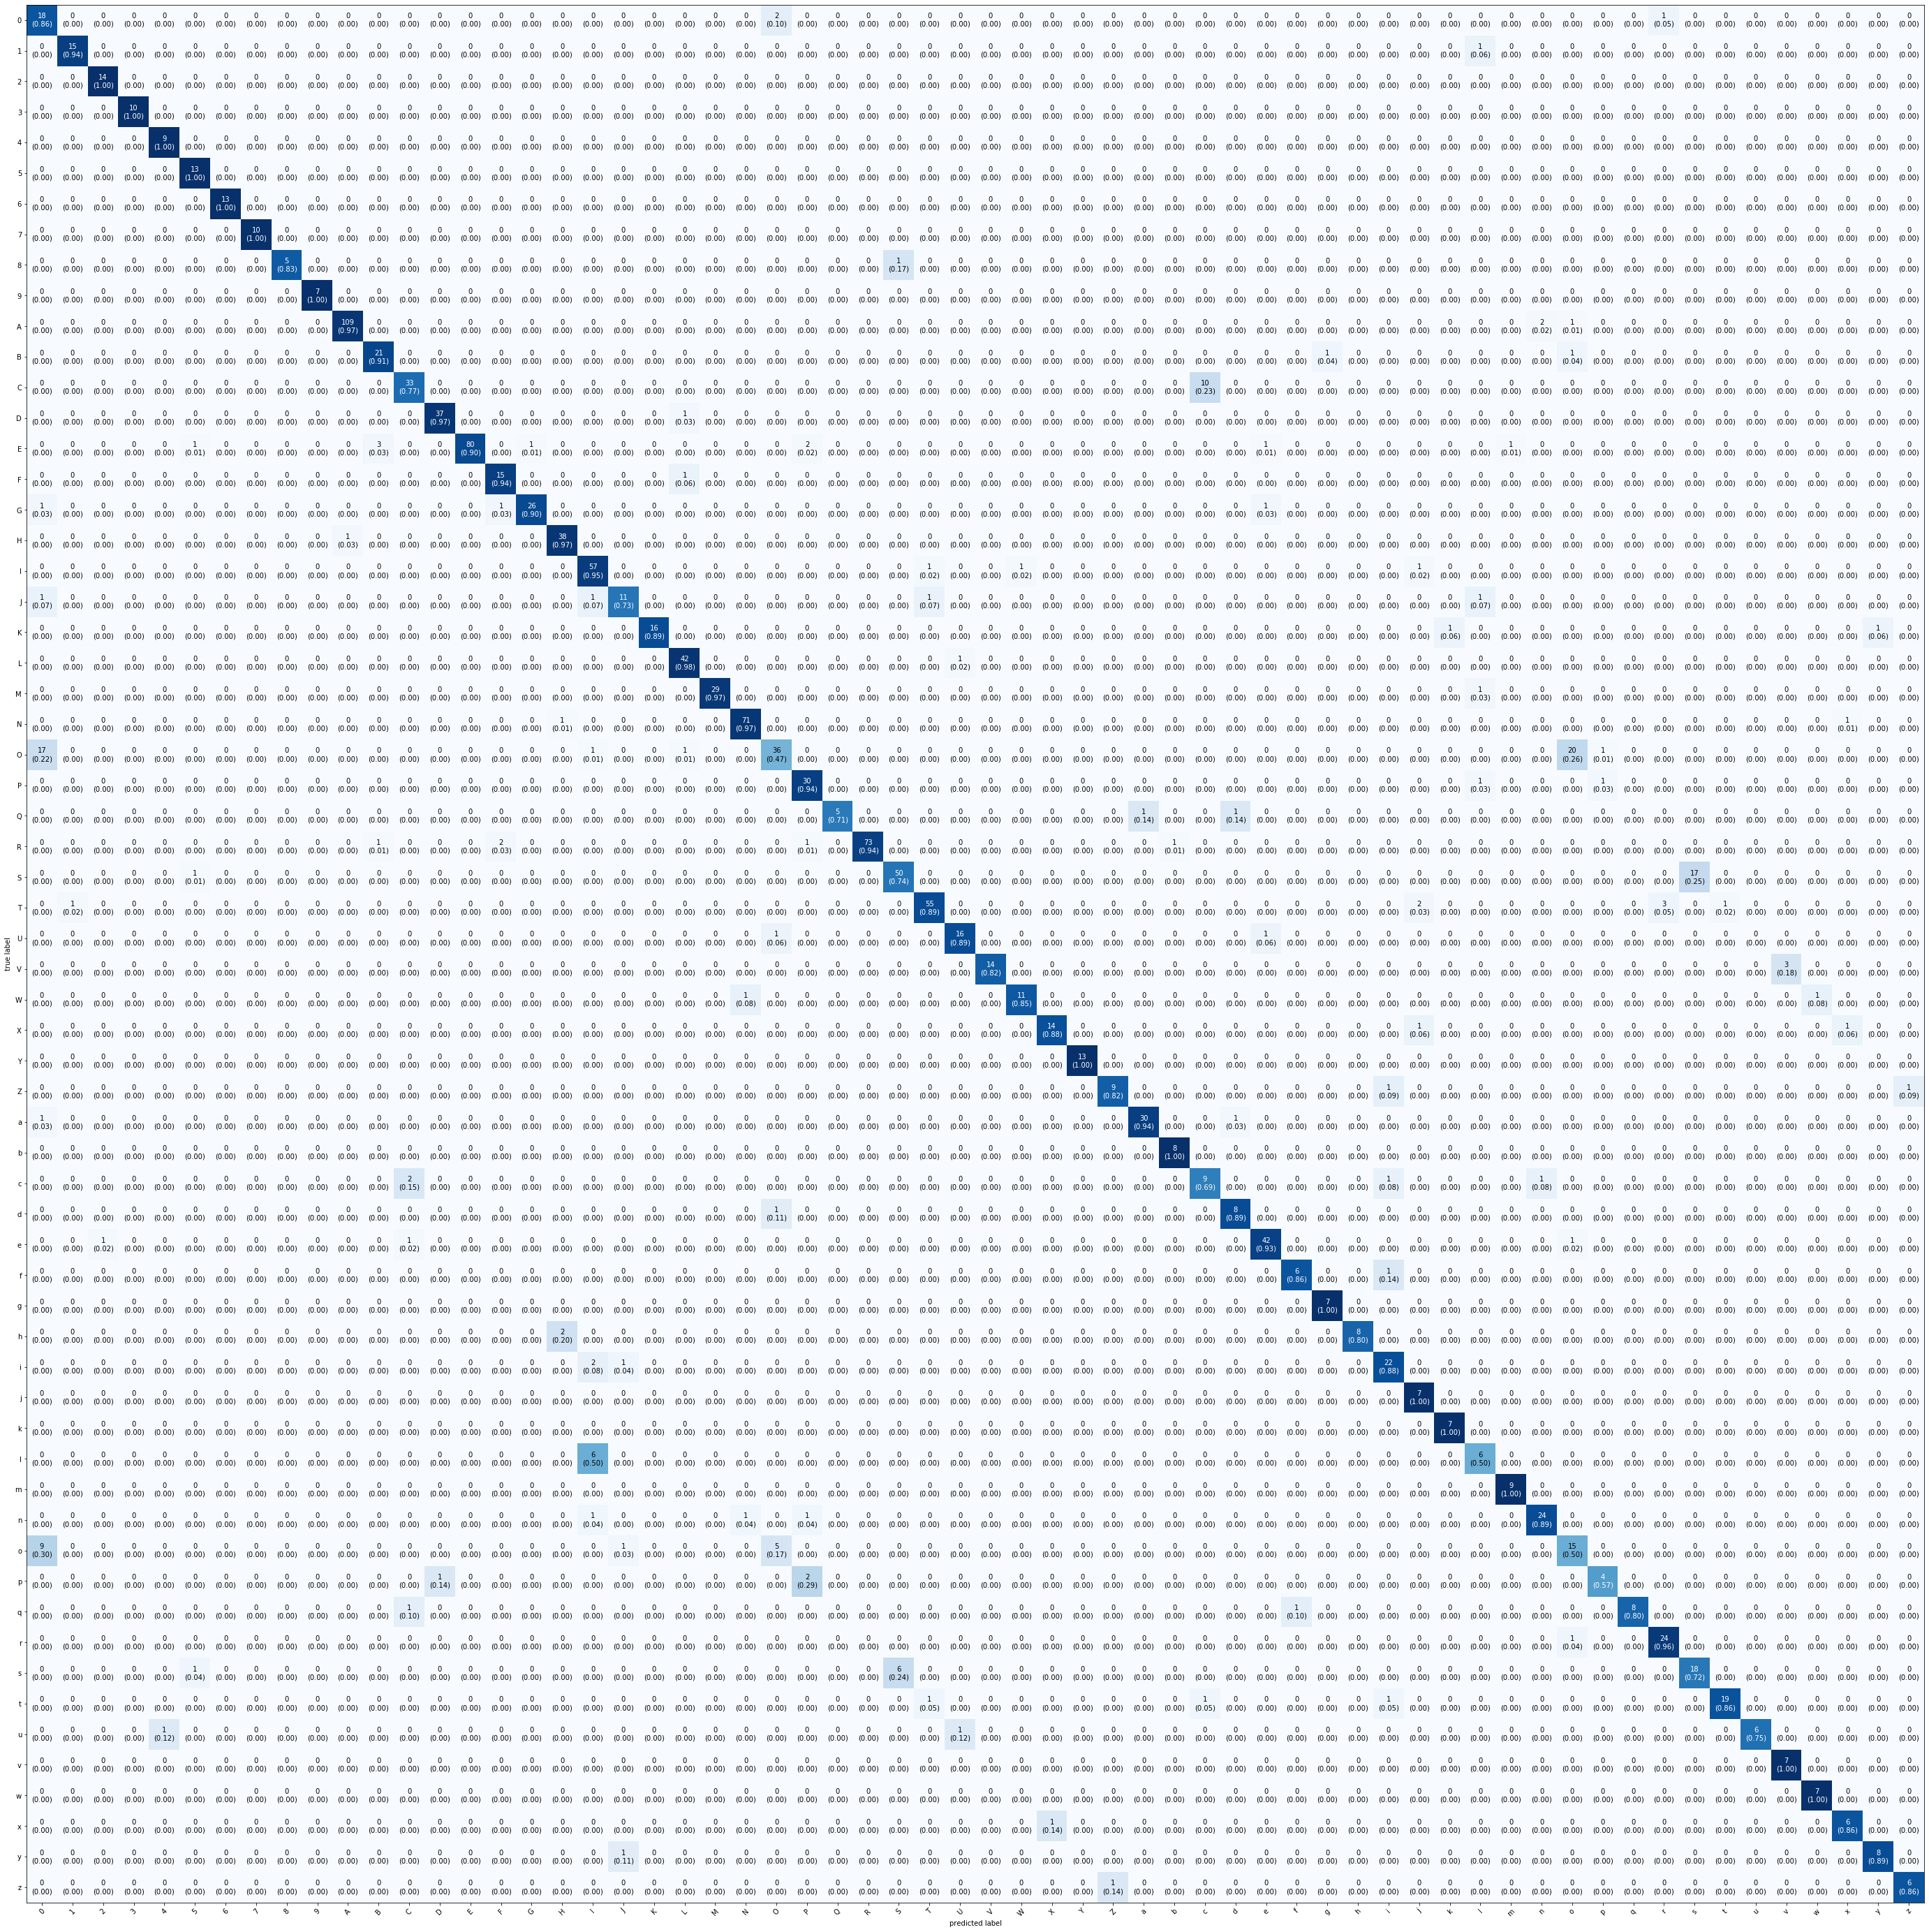

In [22]:
# plot descriptive confusion matrix

fig, ax = plt.subplots(figsize=(50, 50))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
plot_confusion_matrix(conf_mat=cm,
                      show_absolute=True,
                      show_normed=True,
                      class_names=classes,
                      figure=fig,
                      axis=ax)

Using the values in the confusion matrix, I can now compute the precision, recall, and f1 scores for both the whole model and the individual classes.

In [23]:
# compute precision, recall, f1

cm_range = range(len(cm))
true_positives = np.array([cm[i,i] for i in cm_range])
# for both false positives and negatives, subtract the values in the main diagonal
false_positives = np.array([sum(cm[:, i]) for i in cm_range]) - true_positives
false_negatives = np.array([sum(cm[i, :]) for i in cm_range]) - true_positives

precision = np.divide(true_positives, true_positives + false_positives)
recall = np.divide(true_positives, true_positives + false_negatives)
f1 = np.divide(precision + recall, 2)


df_metrics = \
pd.DataFrame(data=[true_positives, false_positives, false_negatives, precision, recall, f1], 
                          index=['true_positives', 'false_positives', 'false_negatives',
                                 'precision', 'recall', 'f1'],
                          columns=classes).\
    transpose().sort_values('f1')

aggregate_metrics = df_metrics.mean()
print(f"precision score: {aggregate_metrics['precision']:.2%}")
print(f"recall score: {aggregate_metrics['recall']:.2%}")
print(f"f1 score: {aggregate_metrics['f1']:.2%}")

precision score: 87.06%
recall score: 87.96%
f1 score: 87.51%


I would consider the scores printed above to be indicators of a good model. Since I have also computed the scores for the individual classes, let's take a look at some of the lowest-scoring classes and see if we can identify why the model may have had trouble with them. The indices (classes) are already sorted by f1 score, so I just select the first ten rows of the dataframe.

## Error Analysis

In [24]:
df_metrics.head(10)

,true_positives,false_positives,false_negatives,precision,recall,f1
o,15.0,24.0,15.0,0.384615,0.500000,0.442308
l,6.0,4.0,6.0,0.600000,0.500000,0.550000
c,9.0,11.0,4.0,0.450000,0.692308,0.571154
s,18.0,17.0,7.0,0.514286,0.720000,0.617143
p,4.0,2.0,3.0,0.666667,0.571429,0.619048
0,18.0,29.0,3.0,0.382979,0.857143,0.620061
O,36.0,9.0,40.0,0.800000,0.473684,0.636842
J,11.0,3.0,4.0,0.785714,0.733333,0.759524
x,6.0,2.0,1.0,0.750000,0.857143,0.803571
S,50.0,7.0,18.0,0.877193,0.735294,0.806244


Looking back at the confusion matrix, there are two prominent diagonals on either side of the main diagonal. Each of these represents the intersection of lowercase labels (or predictions) with uppercase predictions (or classes). Since several letters have similarly-shaped uppercase and lowercase forms, it is unsurprising that this is a prominent area of confusion for the model. Of the ten classes with the lowest f1 scores, o, c, s, p, O, x, and S appear on both of these uppercase-lowercase diagonals.

The classes 0 and l are similarly easy to diagnose. Class 0 frequently gets confused with both forms of the letter o, which is understandable given their shared elliptical shape. Additionally, fully half of the l (lowercase L) samples get confused for I (uppercase i). This second problem is especially understandable given that these two characters are nearly indistinguishable in certain computer fonts, including the one used by default to display markdown text in Jupyter Notebooks - I had to mark these two classes with their opposite-case form to properly distinguish them! Presumably, class I (capital i) did not struggle as much because enough samples featured serifs at the top and bottom of the character to make the appropriate class more obvious.

Class J does not have as tidy an explanation. There are 4 samples with the J label that get misclassified and 3 samples that get erroneously classified as Js themselves, but each of these exhibits only one misclassified sample. My first thought was that perhaps this class was undersampled, so I retrieved its count (printed below):

In [25]:
# J is the tenth letter of the alphabet, and the capital letters immediately follow the 10 numeric characters in this dataset, 
# so the index of J is 19.

counts_per_class[19]

77.0

While additional sampling or data augmentation may have helped, the count of 77 is very close to the computed median of 78, and many (in fact, nearly half) of the other classes performed better with fewer samples.

A second thought that occurred to me is that J has a number of different stylistic variations; in particular, a cursive J may look very different from a typeface J. It may be that the misclassified samples contained one of these variations.